# Dependencies

In [1]:
import pandas as pd
!pip -q install seaborn
import seaborn as sns
!pip install -q missingno
import matplotlib.pyplot as plt
import missingno as msno
!pip -q install scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer
!pip -q install pycountry
import pycountry
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.7 MB/s eta 0:00:00


<h2> Predict whether a security alert represents a real (true positive) threat that requires investigation, or if it's a false/benign positive that can be safely ignored.</h2>

IncidentGrade, mapped to a binary label:

1 = TruePositive → Confirmed threat (requires escalation)

0 = FalsePositive or BenignPositive → No threat (routine or noisy alert)

# Explore 

In [2]:

Data= pd.read_csv('/kaggle/input/microsoft-security-incident-prediction/GUIDE_Train.csv')
df=Data.copy()

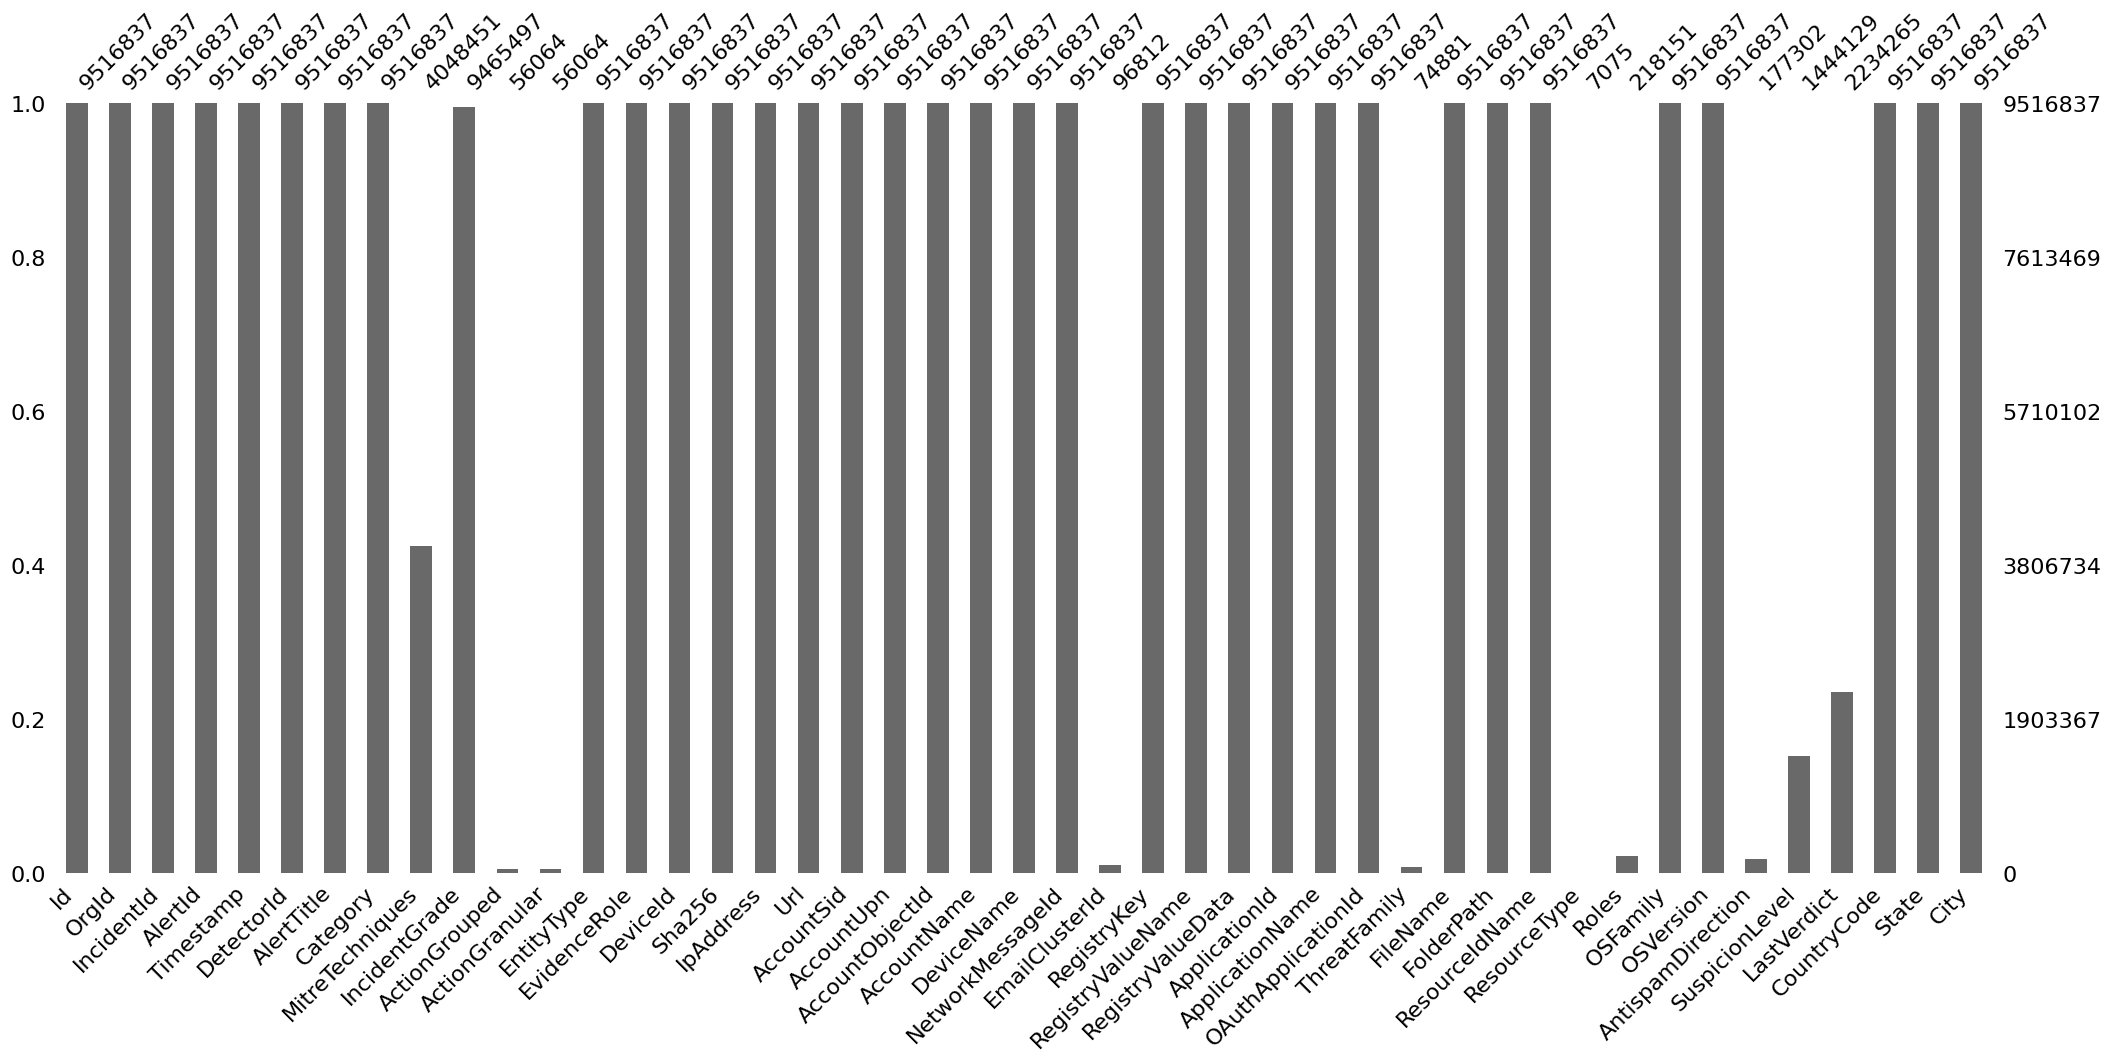

In [3]:
import matplotlib.pyplot as plt
import missingno as msno
plt.figure(figsize=(3, 3))  # width x height in inches
msno.bar(df)
plt.show()
# Missing values across the features 

In [4]:
print(f"⚫ Columns are{df.columns}")

print("---------------------------------------------")

print(f" ⚫ We have an {len(df.columns)} columns in the Data ")
print(f" ⚫ We have an {df.select_dtypes(include='object').shape[1]} Categorial Columns at in the Data ")
print(f" ⚫ We have an {df.select_dtypes(include=['int','float']).shape[1] } integer Columns at in the Data ")
cate=df.select_dtypes(include='object') 
numc=df.select_dtypes(include=['int','float'])

print(f"⚫ Integer Columns  {numc.columns}")
print(f"⚫ Categorial Columns{cate.columns}")
df.shape

⚫ Columns areIndex(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')
---------------------------------------------
 ⚫ We have an 45 columns in the Data 
 ⚫ We have an 14 Categorial Columns at in the Data 
 ⚫ We have an 31 integer Columns at in the Data 
⚫ Integer Columns  Index(['Id', 'OrgId', 

(9516837, 45)

BinaryIncidentGrade  Target Variable 

IncidentGrade, mapped to a binary label:

1 = TruePositive → Confirmed threat (requires escalation)

0 = FalsePositive or BenignPositive → No threat (routine or noisy alert)

In [5]:
df['BinaryIncidentGrade'] = df['IncidentGrade'].apply(lambda x: 1 if x == 'TruePositive' else 0)
alert_risk = df.groupby('AlertTitle')['BinaryIncidentGrade'].mean()
d=df.drop(columns=['IncidentGrade'])


In [6]:
counts = df['BinaryIncidentGrade'].value_counts()
percentages = df['BinaryIncidentGrade'].value_counts(normalize=True).mul(100).round(2)

result = pd.DataFrame({'Count': counts, 'Percentage': percentages})
print(result)


                       Count  Percentage
BinaryIncidentGrade                     
0                    6194124       65.09
1                    3322713       34.91


What is Wilson/Bayes smoothing ?
 
It's a corrected average that prevents misleading extremes when we have very few data points.
AlertTitle 101

Incidents: 2

Total Alerts: 2

Raw Risk = 2 / 2 = 1.0

Smoothed:0.666
Why?

* Because with only 2 examples, we shouldn't fully trust 100% risk — the smoothed value brings it closer to 0.5 to reflect uncertainty.
​


In [7]:
alert_risk2 = df.groupby('AlertTitle')['BinaryIncidentGrade'].sum()
alert_summary = pd.DataFrame({
    'Risk': alert_risk,
    'Count': alert_risk2
})

alpha = 2
beta = 2

# Calculate smoothed risk
alert_summary['SmoothedRisk'] = (
    alert_summary['Risk'] * alert_summary['Count'] + alpha
) / (alert_summary['Count'] + alpha + beta)

alert_summary
SmoothedRisk=alert_summary.SmoothedRisk
df=df.merge(SmoothedRisk,on='AlertTitle' , how ='left')

# Exploratory Data Analysis

Target variable BinaryIncidentGrade is imbalanced.

Class 0 represents approximately 65% of the data.

Class 1 (minority) accounts for about 35%.

Moderate class imbalance

I chose not to manually address class imbalance through resampling, as we used tree-based ensemble models (Random Forest / LightGBM) that support imbalance-aware training via hyperparameters such as class_weight='balanced', scale_pos_weight, or similar class_weight options. This allows the model to adjust for skewed class distributions internally while preserving the original data structure


Class 1 (the minority) will get a higher weight, increasing its impact during model training.

Class 0 (the majority) will get a lower weight, so its dominance doesn't skew the model.

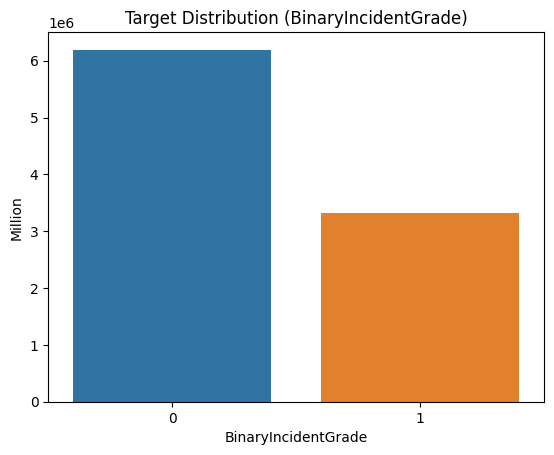

In [8]:
# Target distribution
sns.countplot(x='BinaryIncidentGrade', data=df)
plt.title("Target Distribution (BinaryIncidentGrade)")
plt.ylabel("Million")
plt.show()




-Smoothed risk values are distributed for each class. Higher smoothed risk scores are more concentrated among the positive class

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


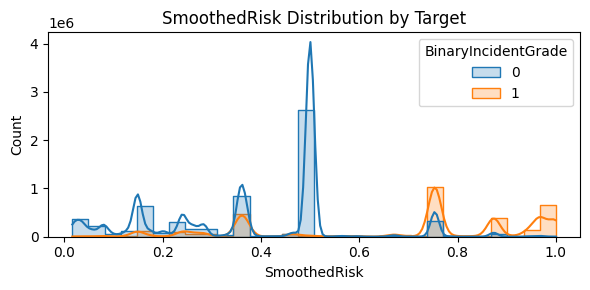

In [9]:
plt.figure(figsize=(6, 3))
sns.histplot(data=df, x='SmoothedRisk', hue='BinaryIncidentGrade', bins=30, kde=True, element='step',  common_norm=False)
plt.title("SmoothedRisk Distribution by Target")
plt.tight_layout()
plt.show()


Hours and Week days might be important Features at the Security Incident 

In [10]:
print(max(df.Timestamp)), print(min(df.Timestamp))
df['Timestamp']=pd.to_datetime(df['Timestamp'])
df['month']=df['Timestamp'].dt.month
df['hour']=df['Timestamp'].dt.hour
df['weekday']=df['Timestamp'].dt.weekday+1
df=df.drop(columns=['Timestamp'])

2024-06-17T14:45:38.000Z
2023-11-20T16:32:22.000Z


In [11]:
cate=df.select_dtypes(include='object') 

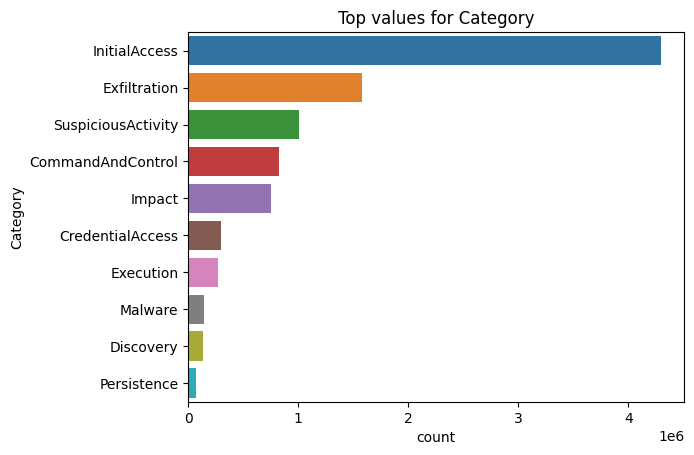

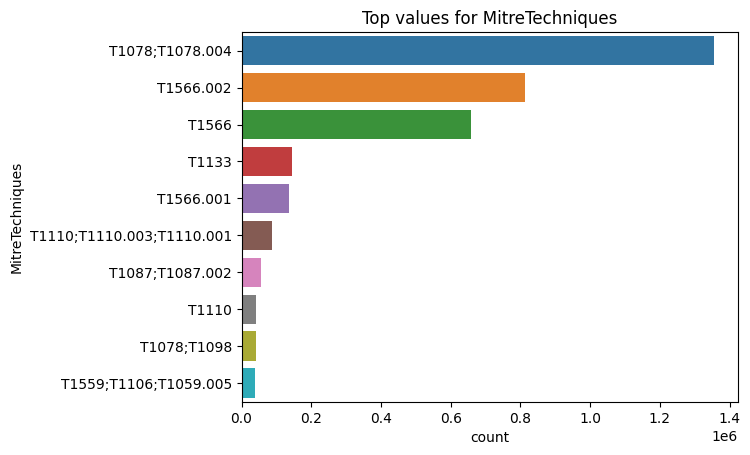

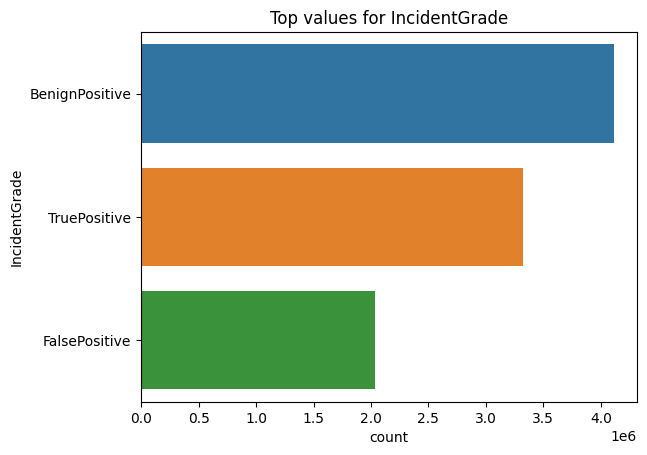

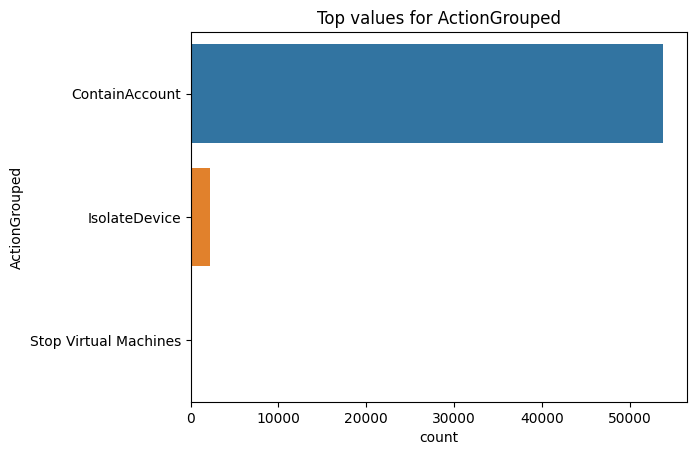

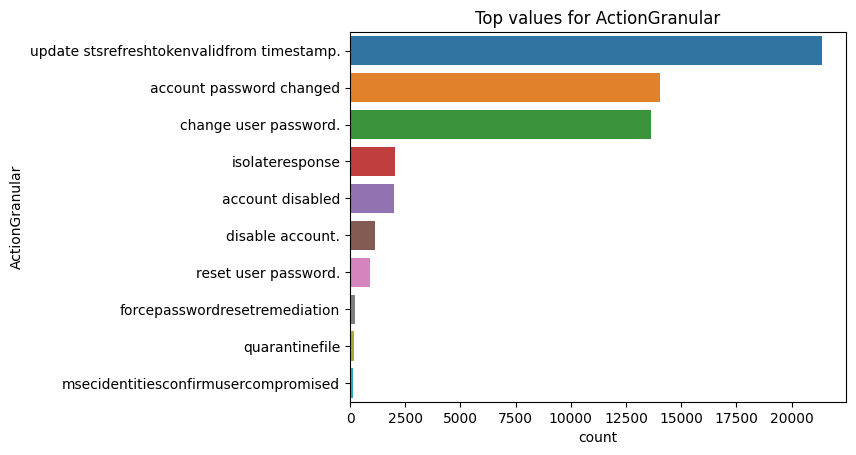

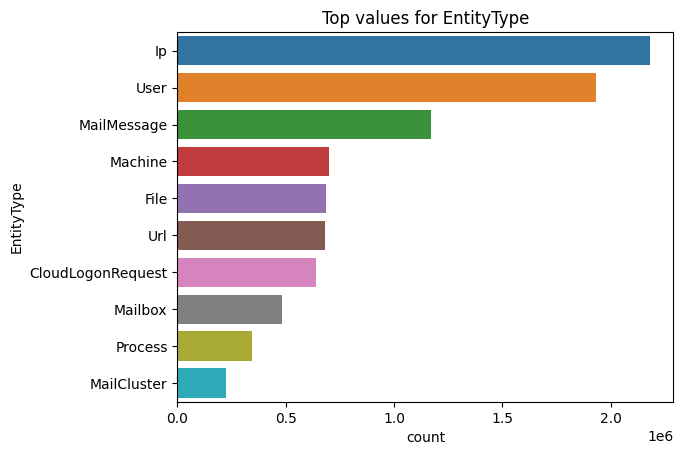

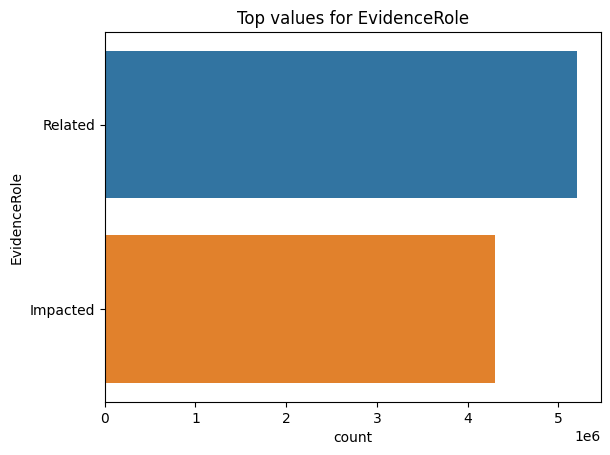

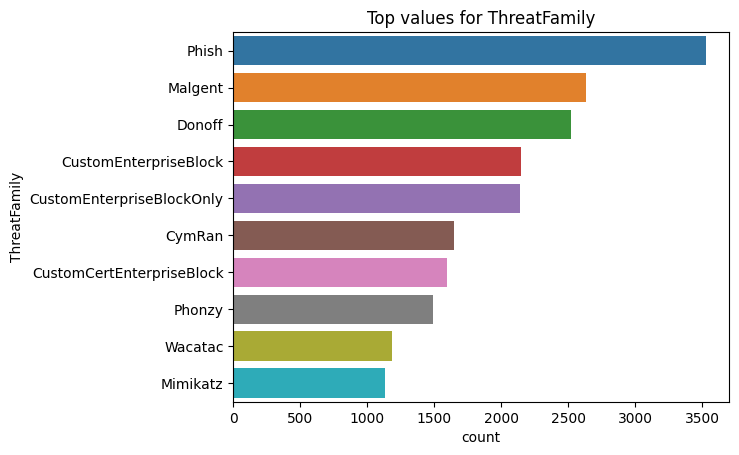

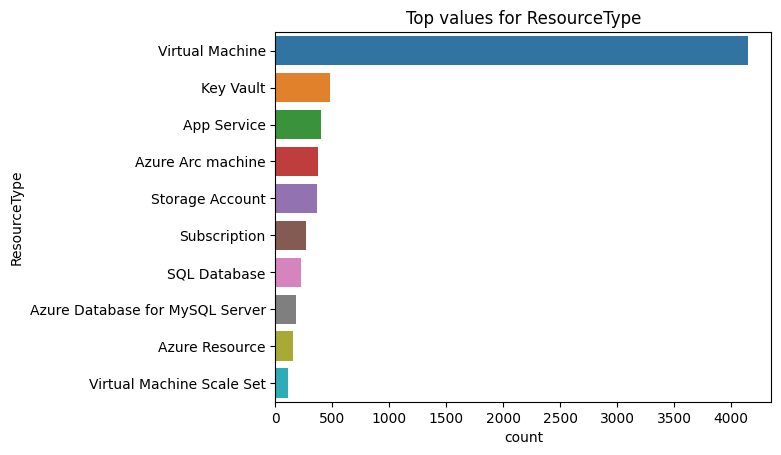

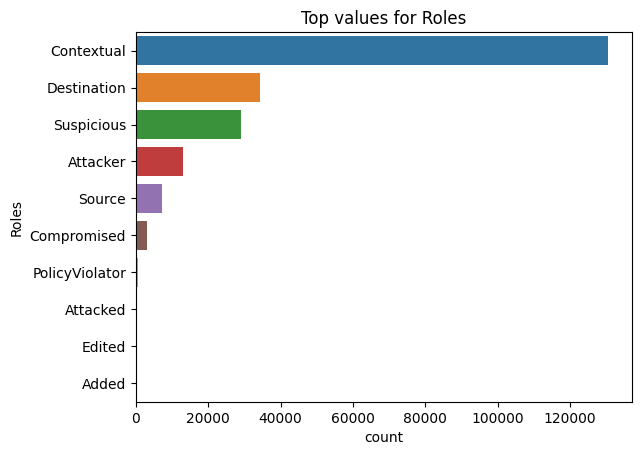

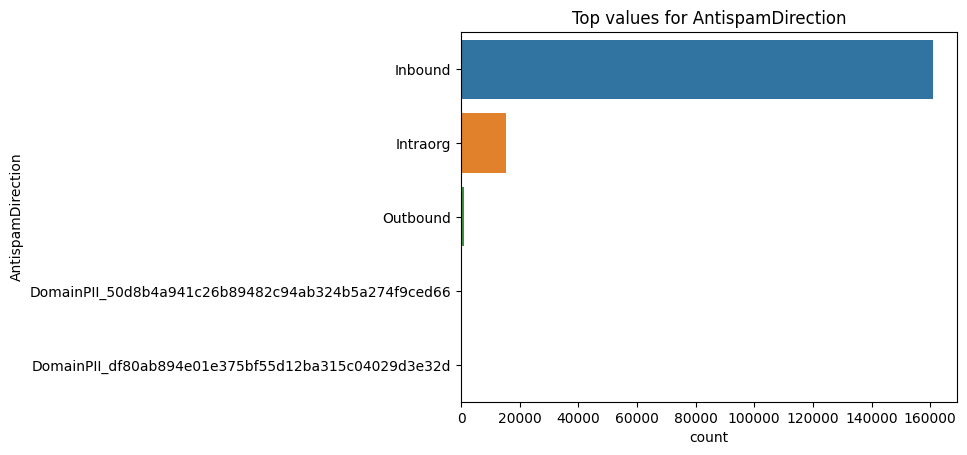

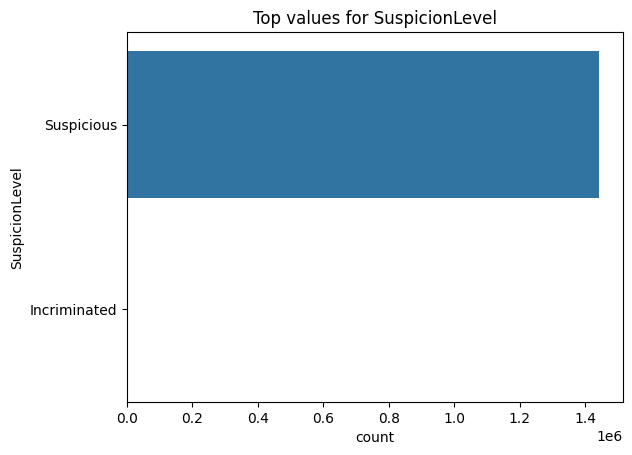

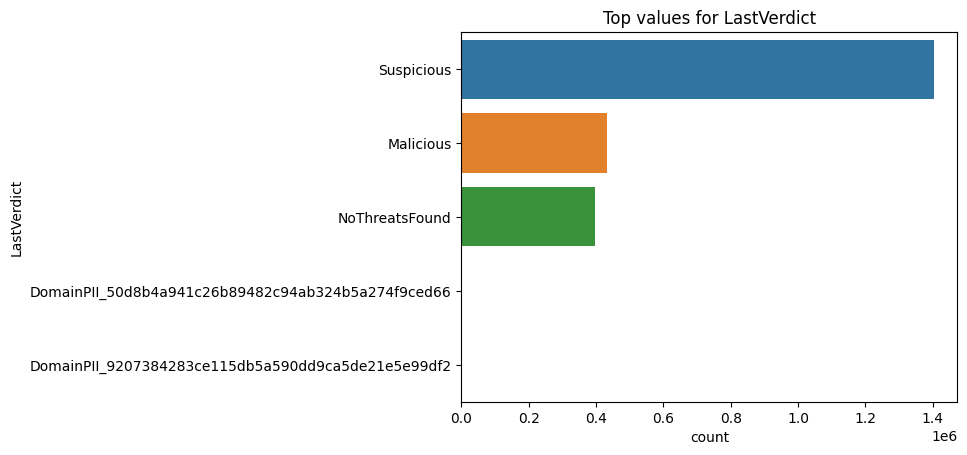

In [12]:
for col in cate:
    sns.countplot(y=col, data=df, order=df[col].value_counts().iloc[:10].index)
    plt.title(f"Top values for {col}")
    plt.show()
 

Tried to match the country codes using Microsoft's ISO database standards, but the mapping was incorrect. Fiji Island alone has 8,766,912 rows — about 90% of the data. This suggests that the city with code 1445 (which has 8,883,778 rows) is likely located in Fiji.

In [13]:
def code_to_country(code):
    try:
        return pycountry.countries.get(numeric=str(code).zfill(3)).name
    except:
        return 'Unknown'
    
n=df.copy()
n['CountryName'] = n['CountryCode'].apply(code_to_country)
n['CountryName'].value_counts()


CountryName
Fiji                                            8766912
Unknown                                          614719
Afghanistan                                       40295
Albania                                           17934
Antarctica                                        15850
                                                 ...   
South Georgia and the South Sandwich Islands          1
Falkland Islands (Malvinas)                           1
Ecuador                                               1
Estonia                                               1
Cuba                                                  1
Name: count, Length: 70, dtype: int64

In [14]:
state_counts = df['State'].value_counts()
state_counts.head(10)


State
1445    8883778
0        103868
1         40312
2         28875
3         23048
4         19133
5         15771
6         15579
7         14495
8         12481
Name: count, dtype: int64

This feature engineering step adds a geolocation frequency feature, which can be useful  to indicate how common a particular location is in the dataset—potentially useful for detecting rare locations or regional patterns.

CountryCode, State, and City into a single GeoLoc identifier, then calculates the normalized frequency of each unique location. The resulting frequency (GeoLoc_freq) is added to the DataFrame, and the original location columns are dropped.

In [15]:
df['GeoLoc'] = df['CountryCode'].astype(str) + "_" + df['State'].astype(str) + "_" + df['City'].astype(str)
geo_freq = df['GeoLoc'].value_counts(normalize=True)
df['GeoLoc_freq'] = df['GeoLoc'].map(geo_freq)
df.drop(columns=['CountryCode', 'State', 'City', 'GeoLoc'], inplace=True)

# Confirm result
df[['GeoLoc_freq']].describe()

,GeoLoc_freq
count,9.516837e+06
mean,8.487095e-01
std,2.476605e-01
min,1.050769e-07
25%,9.211619e-01
50%,9.211619e-01
75%,9.211619e-01
max,9.211619e-01


# Explore The Categorial Features



⚠️ Some rare values   Examples  Roles(Added, Edited, PolicyViolator) occur <10×

grouping rare roles into "Other" before encoding

This code fills missing values in specific columns of a DataFrame (df) with the string 'missing' or 'Missing'. Then, it groups infrequent values (less than 100 occurrences) in the LastVerdict column under a common label 'Other' and shows the count of unique values in selected columns.

In [16]:
df['Roles']=df.Roles.fillna('missing')
df['ActionGrouped'] = df['ActionGrouped'].fillna('Missing')
df['SuspicionLevel'] = df['SuspicionLevel'].fillna('Missing')
df['LastVerdict'] = df['LastVerdict'].fillna('Missing')
# Group rare verdicts
verdict_counts = df['LastVerdict'].value_counts()
rare_verdicts=verdict_counts[verdict_counts<100].index
df['LastVerdict'] = df['LastVerdict'].replace(rare_verdicts, 'Other')
df[['Roles', 'ActionGrouped', 'SuspicionLevel', 'LastVerdict']].nunique()

Roles             11
ActionGrouped      4
SuspicionLevel     3
LastVerdict        6
dtype: int64

<h3>Frequent Encoding </h3>

Many of the columns (e.g., 'ThreatFamily', 'Category', 'LastVerdict') likely contain a large number of unique values. One-hot encoding would create a new column for each unique category, massively increasing the feature space and memory usage and may casue curse of dimensionality. Frequency gives us a simple, bounded signal

In [17]:
cols = [
    'ThreatFamily', 'AntispamDirection', 'ActionGranular',
    'LastVerdict', 'ResourceType', 'Roles', 'ActionGrouped', 'EntityType','Category' 
]

for col in cols:
    print(f"\n📊 Analyzing column: {col}")
    print("🔹 Unique Values:", df[col].nunique())
    print("\n🔹 Top 10 Values:\n", df[col].value_counts().head(10))
    print("\n🔹 Missing Ratio:", df[col].isna().mean())
    print("\n🔹 Target Mean by Category:\n", df.groupby(col)['BinaryIncidentGrade'].mean().sort_values(ascending=False))
    print("🔹 Rare Categories (<100 rows):", sum(df[col].value_counts() < 100))
    
    # Fill missing
    df[col] = df[col].fillna('Missing')

    # Frequency encode
    freq = df[col].value_counts(normalize=True)
    df[f"{col}_freq"] = df[col].map(freq)

    # Drop original
    df.drop(columns=col, inplace=True)



📊 Analyzing column: ThreatFamily
🔹 Unique Values: 1745

🔹 Top 10 Values:
 ThreatFamily
Phish                        3526
Malgent                      2636
Donoff                       2519
CustomEnterpriseBlock        2145
CustomEnterpriseBlockOnly    2139
CymRan                       1648
CustomCertEnterpriseBlock    1595
Phonzy                       1493
Wacatac                      1185
Mimikatz                     1131
Name: count, dtype: int64

🔹 Missing Ratio: 0.9921317345248216

🔹 Target Mean by Category:
 ThreatFamily
Evidpatch        1.0
Epatch           1.0
Roduk            1.0
CVE-2009-3867    1.0
Remeshelsz       1.0
                ... 
DarkCloud        0.0
Neoreblamy       0.0
DarkBit          0.0
Neshta           0.0
Locky            0.0
Name: BinaryIncidentGrade, Length: 1745, dtype: float64
🔹 Rare Categories (<100 rows): 1614

📊 Analyzing column: AntispamDirection
🔹 Unique Values: 5

🔹 Top 10 Values:
 AntispamDirection
Inbound                                          

In [18]:
cols = ['SuspicionLevel', 'EvidenceRole']

for col in cols:
    print(f"\n📊 Analyzing column: {col}")
    print("🔹 Unique Values:", df[col].nunique())
    print("\n🔹 Top 10 Values:\n", df[col].value_counts().head(10))
    print("\n🔹 Missing Ratio:", df[col].isna().mean())
    print("\n🔹 Target Mean by Category:\n", df.groupby(col)['BinaryIncidentGrade'].mean().sort_values(ascending=False))
    print("🔹 Rare Categories (<100 rows):", sum(df[col].value_counts() < 100))
    
    # Fill missing
    df[col] = df[col].fillna('Missing')
    
    # Group rare categories
    counts = df[col].value_counts()
    rare = counts[counts < 100].index

    df[col] = df[col].replace(rare, 'Other')
    
    # One-hot encode
    df = pd.get_dummies(df, columns=[col], drop_first=True)



📊 Analyzing column: SuspicionLevel
🔹 Unique Values: 3

🔹 Top 10 Values:
 SuspicionLevel
Missing         8072708
Suspicious      1442614
Incriminated       1515
Name: count, dtype: int64

🔹 Missing Ratio: 0.0

🔹 Target Mean by Category:
 SuspicionLevel
Missing         0.372889
Suspicious      0.216546
Incriminated    0.064686
Name: BinaryIncidentGrade, dtype: float64
🔹 Rare Categories (<100 rows): 0


Identify and handle missing or improperly formatted entries.

In [ ]:
value_counts = df['MitreTechniques'].value_counts()
total_rows = len(df)

# Create a new Series with percentage values
percentages = (value_counts / total_rows) * 100

# Optionally combine with counts for readability
technique_stats = pd.DataFrame({
    'count': value_counts,
    'percentage': percentages
})

print(f" Missing are  {df['MitreTechniques'].isna().sum()}"), 
print(technique_stats.head(5))

This section processes the MitreTechniques column by splitting multiple techniques into lists, selecting the top 30 most frequent techniques, and filtering each entry accordingly. It then applies one-hot encoding to convert these techniques into binary features

In [ ]:
# Step 1: Split the semicolon-separated string into lists
df['MitreList'] = df['MitreTechniques'].apply(lambda x: x.split(';') if pd.notna(x) else [])

# Step 2: Identify top 30 most common techniques
all_techs = [tech for sublist in df['MitreList'] for tech in sublist]
top_techs = [tech for tech, _ in Counter(all_techs).most_common(30)]
top_tech_set = set(top_techs)

# Step 3: Filter each list to include only top techniques
df['FilteredMitreList'] = df['MitreList'].apply(lambda x: [tech for tech in x if tech in top_tech_set])

# Step 4: One-hot encode using MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=top_techs)
tech_matrix = pd.DataFrame(mlb.fit_transform(df['FilteredMitreList']),
                           columns=mlb.classes_, index=df.index)

# Step 5: Merge encoded columns into df and drop original string columns
df = pd.concat([df, tech_matrix], axis=1)
df.drop(columns=['MitreTechniques', 'MitreList', 'FilteredMitreList'], inplace=True)

This columns have been transformed , so it will be dropped to Prevent Data leakeage (Target Leakage) Type 

In [ ]:
df.select_dtypes(include="object")


# Building Model

These are IDs or hashed keys , IpAddress, URL, EmailClusterId, not true numeric features. They:

Have no semantic meaning

Won’t generalize across samples




In [ ]:
drop_redundant = ['Id','IncidentId','Sha256','DeviceId','AccountSid', 'AccountUpn', 'AccountObjectId', 
    'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryValueName', 'RegistryKey', 'ApplicationId','OAuthApplicationId', 'FileName',
    'ResourceIdName', 'EmailClusterId','IncidentGrade', 'OrgId','DetectorId', 'AlertId']

In [ ]:


X = df.drop(columns=drop_redundant + ['BinaryIncidentGrade'])
y = df['BinaryIncidentGrade']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_valid.shape)
print(y_train.mean(), y_valid.mean())


In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import pandas as pd

# Sample from df if it's very large (you already did this)
d_sample = df.sample(n=100000, random_state=42)  # Optional: set random_state for reproducibility

X= d_sample.drop(columns=drop_redundant + ['BinaryIncidentGrade'])
y = d_sample['BinaryIncidentGrade']

# For classification:
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# For regression tasks, uncomment below and comment out the classification line
# mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=42)

# Wrap results in a Series and sort
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

print(mi_series)


Since the dataset is Big and it will take a long time for Mutual information 

I tried Use a Tree-Based Model for Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X= df.drop(columns=drop_redundant + ['BinaryIncidentGrade'])
y = df['BinaryIncidentGrade']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [300, 600, 750],
    'criterion': ['gini', 'entropy']
}

In [ ]:
import time
print(" Starting cross-validation training...")

start = time.time()
# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=6),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=2
)
grid_search.fit(X_train, y_train)

end = time.time()

duration = end - start

print(f"⏱️ Grid search completed in {duration:.2f} seconds")

# Results
print("✅ Best parameters found:")
print(grid_search.best_params_)

print(f" Best ROC AUC score from CV: {grid_search.best_score_:.4f}")

# Optional: Evaluate on the held-out validation set
best_model = grid_search.best_estimator_
y_valid_pred = best_model.predict_proba(X_valid)[:, 1]
valid_auc = roc_auc_score(y_valid, y_valid_pred)
print(f"📊 ROC AUC on validation set: {valid_auc:.4f}")

Results

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Grid search completed in 14207.01 seconds

Best parameters found:


{'criterion': 'gini', 'n_estimators': 750}

Best ROC AUC from cross-validation: 0.9491

ROC AUC on validation set: 0.9504

# Notes

How to Think When Building the Model




1-Label Availability: Is the data labeled? Use supervised models. No labels? Consider unsupervised or semi-supervised methods.


2-Understand the Task Type

Binary Classification : 
* Use: Logistic Regression, Decision Trees, Random Forests, SVM, Neural Networks

Regression: Predict a continuous value (e.g., house prices, sales forecasts).
* Use: Linear Regression, Ridge/Lasso, XGBoost, Gradient Boosting, Neural Networks


3-Model Goals

*  Do you need interpretability ? Do I need to explain why the model produced these results to in detail ?" (e.g., in compliance settings — use decision trees or linear models)

* Is accuracy or speed more important?

* Is Data is Imbalanced : should you OverSample or UnderSample using SMOTE ,  or You might use tree models like XGboost  And give less weight to the major class



